In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [2]:
train = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train.csv")
test = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/test.csv")
sample = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv")
updates = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv")


In [3]:
train.head(1)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7


<AxesSubplot:ylabel='Frequency'>

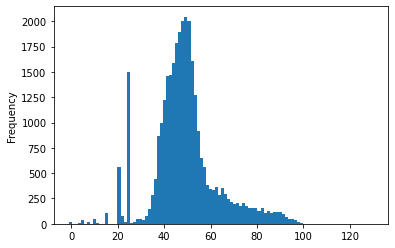

In [4]:
train.tm.plot(kind ="hist", bins = 100)

In [5]:
train.tm.describe()

count    31390.000000
mean        49.147337
std         14.010089
min         -1.000000
25%         42.100000
50%         48.000000
75%         53.800000
max        130.000000
Name: tm, dtype: float64